# MovieLens-RAG-Recommendation-System

In [2]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt

import spacy
from wordcloud import WordCloud
import seaborn as sns
import re
import unidecode

nlp=spacy.load("en_core_web_sm")

In [3]:
# Reading files
ratings=pd.read_csv('ratings.csv')
movies=pd.read_csv("movies.csv")
tags=pd.read_csv("tags.csv")
scores=pd.read_csv("genome-scores.csv")
g_tages=pd.read_csv("genome-tags.csv")

In [4]:
movies.shape

(86537, 3)

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [8]:
scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [9]:
g_tages.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [10]:
movie_ratings=movies.merge(ratings,on="movieId") # merging dataframes
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [11]:
tags

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746
...,...,...,...,...
2328310,330923,176599,politically correct,1507547491
2328311,330933,3317,coming of age,1351279384
2328312,330933,3317,sexuality,1351279389
2328313,330947,5782,Not Luc Besson,1154110902


In [12]:
tags.drop("timestamp",axis="columns",inplace=True)
tags["tag"]=tags["tag"].astype(str)
tags

,userId,movieId,tag
0,10,260,good vs evil
1,10,260,Harrison Ford
2,10,260,sci-fi
3,14,1221,Al Pacino
4,14,1221,mafia
...,...,...,...
2328310,330923,176599,politically correct
2328311,330933,3317,coming of age
2328312,330933,3317,sexuality
2328313,330947,5782,Not Luc Besson


In [13]:
tags[tags["movieId"]==1]['tag'].values

array(['animation', 'friendship', 'toys', ..., 'Pixar animation',
       'Tom Hanks', 'é˜®ä¸€é¸£'], dtype=object)

In [14]:
movie_tags = (                                          # extracting tags
    tags.groupby("movieId")["tag"]
        .apply(lambda x: " ".join(sorted(set(x))))
        .reset_index()
        .rename(columns={"tag": "tags"})
)
movie_tags

,movieId,tags
0,1,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,2,1860s 1960s 1990s 19th century 20th century 4k...
2,3,Ann Margaret Burgess Meredith CLV Daryl Hannah...
3,4,CLV based on novel or book characters chick fl...
4,5,4th wall CLV Comedy Diane Keaton Fantasy Steve...
...,...,...
53447,288765,apocalypse bad science plot holes post-apocaly...
53448,288779,Don Camillo Series
53449,288849,addiction animation short film
53450,288937,anime


In [15]:
movie_tags["tags"][0]

"1990s 2009 reissue in Stereoscopic 3-D 3 dimensional 3D 3d 55 movies every kid should see--Entertainment Weekly American Animation Animation Animation  BD-Video Best of Rotten Tomatoes: All Time Buzz Lightyear CG animation CGI CGI classic CLV Cartoon Comedy  DARING RESCUES DVD-Video Disney Disney animated feature Engaging Family cartoon HEROIC MISSION John Lasseter National Film Registry Os dois viram Oscar (Best Picture) Oscar (Special Achievement) Owned Pixar Pixar animation TOYS COME TO LIFE Tim Allen Tom Hanks Toy Story Tumey's To See Again Tumey's VHS TÃ©a Leoni does not star in this movie UNLIKELY FRIENDSHIPS USA Want Watched Woody accepting reality action action figure action figures ad for toys adventure affection alien almost favorite animated animated dog animated fictional tv commercial animation animmation antenna anthropomorphic toy anthropomorphism apology arcade arcade game arm asking directions astronaut audio flashback avi baby baby monitor backfire backyard bad guy b

In [16]:
movie_ratings

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738
...,...,...,...,...,...,...
33832157,288967,State of Siege: Temple Attack (2021),Action|Drama,47791,3.5,1689748357
33832158,288971,Ouija Japan (2021),Action|Horror,98408,0.5,1689798322
33832159,288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary,154483,4.0,1689812351
33832160,288977,Skinford: Death Sentence (2023),Crime|Thriller,291389,3.0,1689815902


In [17]:
df=movie_ratings.merge(movie_tags,on=["movieId"])
df

,movieId,title,genres,userId,rating,timestamp,tags
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,1225734739,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,835815971,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.0,974518024,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,3.0,1430666394,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,5.0,862500738,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...
...,...,...,...,...,...,...,...
33688651,288765,Bird Box Barcelona (2023),Horror|Thriller,236712,2.0,1689462634,apocalypse bad science plot holes post-apocaly...
33688652,288765,Bird Box Barcelona (2023),Horror|Thriller,243444,0.5,1689494308,apocalypse bad science plot holes post-apocaly...
33688653,288765,Bird Box Barcelona (2023),Horror|Thriller,276269,1.0,1689152119,apocalypse bad science plot holes post-apocaly...
33688654,288849,Colaholic (2018),(no genres listed),95007,3.0,1689268843,addiction animation short film


In [18]:
df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp', 'tags'], dtype='object')

In [19]:
df=df.groupby(['movieId', 'title', 'genres', 'tags'])['rating'].mean().to_frame().reset_index() # Aggregating ratings by average
df

,movieId,title,genres,tags,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...,3.893508
1,2,Jumanji (1995),Adventure|Children|Fantasy,1860s 1960s 1990s 19th century 20th century 4k...,3.278179
2,3,Grumpier Old Men (1995),Comedy|Romance,Ann Margaret Burgess Meredith CLV Daryl Hannah...,3.171271
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,CLV based on novel or book characters chick fl...,2.868395
4,5,Father of the Bride Part II (1995),Comedy,4th wall CLV Comedy Diane Keaton Fantasy Steve...,3.076957
...,...,...,...,...,...
50149,288747,LOLA (2023),Drama|Sci-Fi,Nazis World War II black and white interesting...,3.250000
50150,288753,The Deep Web: Murdershow (2023),Horror|Thriller,deep web horror thriller,1.714286
50151,288765,Bird Box Barcelona (2023),Horror|Thriller,apocalypse bad science plot holes post-apocaly...,2.468750
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000


In [20]:
genres=df["genres"].str.replace("|",",").values
genres

array(['Adventure,Animation,Children,Comedy,Fantasy',
       'Adventure,Children,Fantasy', 'Comedy,Romance', ...,
       'Horror,Thriller', '(no genres listed)', 'Drama'], dtype=object)

In [21]:
g=set()
for x in genres:
    if x!='(no genres listed)':
        g.update(x.split(","))
g=list(g)
g

['Romance',
 'Crime',
 'Animation',
 'War',
 'Thriller',
 'Fantasy',
 'Sci-Fi',
 'Drama',
 'Action',
 'Film-Noir',
 'Children',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Adventure',
 'Western',
 'Documentary',
 'Comedy']

In [22]:
for x in range(len(g)):
    g[x]=g[x].lower()
g

['romance',
 'crime',
 'animation',
 'war',
 'thriller',
 'fantasy',
 'sci-fi',
 'drama',
 'action',
 'film-noir',
 'children',
 'horror',
 'imax',
 'musical',
 'mystery',
 'adventure',
 'western',
 'documentary',
 'comedy']

## Pre-processing

In [23]:
# Pre-processing text data
def website(x):
    return re.findall(r"https?://\S+|www\S+",x)

In [24]:
df["websites"]=df["tags"].apply(website)
df["websites"].value_counts()

websites
[]                                                                                                                                                                                                                                                                                                                                                                                50119
[https://movielens.org/tag/:animation]                                                                                                                                                                                                                                                                                                                                                1
[http://www.tu.tv/videos/el-hombre-que-plantaba-arboles]                                                                                                                                                                                       

In [25]:
def htags(x):
    return re.findall(r">|<", x)

In [26]:
df["html"]=df["tags"].apply(htags)
df["html"].value_counts()

html
[]        50075
[<]          40
[>]          36
[<, >]        2
[>, >]        1
Name: count, dtype: int64

In [27]:
df["genres"].value_counts()

genres
Drama                                              7467
Comedy                                             4251
Documentary                                        4061
(no genres listed)                                 2251
Comedy|Drama                                       1956
                                                   ... 
Adventure|Documentary|Drama|War                       1
Action|Adventure|Drama|Romance|Thriller|Western       1
Comedy|Horror|IMAX                                    1
Action|Comedy|Sci-Fi|IMAX                             1
Animation|Children|Comedy|Fantasy|Romance             1
Name: count, Length: 1599, dtype: int64

In [28]:
df["genres"]=df["genres"].str.replace("|"," ")
df

,movieId,title,genres,tags,rating,websites,html
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in Stereoscopic 3-D 3 dimen...,3.893508,[https://movielens.org/tag/:animation],[]
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th century 4k...,3.278179,[],[]
2,3,Grumpier Old Men (1995),Comedy Romance,Ann Margaret Burgess Meredith CLV Daryl Hannah...,3.171271,[],[]
3,4,Waiting to Exhale (1995),Comedy Drama Romance,CLV based on novel or book characters chick fl...,2.868395,[],[]
4,5,Father of the Bride Part II (1995),Comedy,4th wall CLV Comedy Diane Keaton Fantasy Steve...,3.076957,[],[]
...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,Nazis World War II black and white interesting...,3.250000,[],[]
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[]
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post-apocaly...,2.468750,[],[]
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[]


In [29]:
def regx(x):
    x = unidecode.unidecode(x)
    clean = re.sub(r"https?://\S+|www\S+","",x)       # remove URLs
    clean = re.sub(r"[<>]"," ",clean)                 # remove <>
    clean = re.sub(r"(\d)\s*d\b", r"\1d", clean)      # fix 3d / 3 d

    clean = re.sub(r"(\w)\s+'s\b", r"\1's", clean)

    clean = re.sub(r"[^\x00-\x7F]+", " ", clean)      # remove non-ascii
    clean = re.sub(r"[^0-9A-Za-z\s']", " ", clean)    # keep apostrophes
    clean = re.sub(r"\s+"," ",clean).lower().strip()  # collapse spaces

    tokens = clean.split()
    unique_tokens = list(dict.fromkeys(tokens))
    return " ".join(unique_tokens)

In [30]:
df["tags"]=df["tags"].apply(regx)

In [31]:
df

,movieId,title,genres,tags,rating,websites,html
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.893508,[https://movielens.org/tag/:animation],[]
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.278179,[],[]
2,3,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.171271,[],[]
3,4,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.868395,[],[]
4,5,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.076957,[],[]
...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.250000,[],[]
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[]
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.468750,[],[]
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[]


In [32]:
def spacy_clean(x):
    cleaned=[]
    for docs in nlp.pipe(x,batch_size=500):
        tokens=[token.text for token in docs if not token.is_space and not token.is_punct]
        cleaned.append(" ".join(tokens))
    return cleaned

In [33]:
df["clean_tags"]=spacy_clean(df["tags"])

In [34]:
df

,movieId,title,genres,tags,rating,websites,html,clean_tags
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1990s 2009 reissue in stereoscopic 3 d dimensi...,3.893508,[https://movielens.org/tag/:animation],[],1990s 2009 reissue in stereoscopic 3 d dimensi...
1,2,Jumanji (1995),Adventure Children Fantasy,1860s 1960s 1990s 19th century 20th 4k adaptat...,3.278179,[],[],1860s 1960s 1990s 19th century 20th 4k adaptat...
2,3,Grumpier Old Men (1995),Comedy Romance,ann margaret burgess meredith clv daryl hannah...,3.171271,[],[],ann margaret burgess meredith clv daryl hannah...
3,4,Waiting to Exhale (1995),Comedy Drama Romance,clv based on novel or book characters chick fl...,2.868395,[],[],clv based on novel or book characters chick fl...
4,5,Father of the Bride Part II (1995),Comedy,4th wall clv comedy diane keaton fantasy steve...,3.076957,[],[],4th wall clv comedy diane keaton fantasy steve...
...,...,...,...,...,...,...,...,...
50149,288747,LOLA (2023),Drama Sci-Fi,nazis world war ii black and white interesting...,3.250000,[],[],nazis world war ii black and white interesting...
50150,288753,The Deep Web: Murdershow (2023),Horror Thriller,deep web horror thriller,1.714286,[],[],deep web horror thriller
50151,288765,Bird Box Barcelona (2023),Horror Thriller,apocalypse bad science plot holes post apocaly...,2.468750,[],[],apocalypse bad science plot holes post apocaly...
50152,288849,Colaholic (2018),(no genres listed),addiction animation short film,3.000000,[],[],addiction animation short film


In [35]:
df.columns

Index(['movieId', 'title', 'genres', 'tags', 'rating', 'websites', 'html',
       'clean_tags'],
      dtype='object')

In [36]:
df=df[['title', 'genres', 'rating', 'clean_tags']]
df

,title,genres,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.893508,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,3.278179,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,3.171271,ann margaret burgess meredith clv daryl hannah...
3,Waiting to Exhale (1995),Comedy Drama Romance,2.868395,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,3.076957,4th wall clv comedy diane keaton fantasy steve...
...,...,...,...,...
50149,LOLA (2023),Drama Sci-Fi,3.250000,nazis world war ii black and white interesting...
50150,The Deep Web: Murdershow (2023),Horror Thriller,1.714286,deep web horror thriller
50151,Bird Box Barcelona (2023),Horror Thriller,2.468750,apocalypse bad science plot holes post apocaly...
50152,Colaholic (2018),(no genres listed),3.000000,addiction animation short film


In [37]:
df["clean_tags"].values[0]

"1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat bra

In [38]:
def r(x):
    return round(x,2)

In [39]:
df["rating"]=df["rating"].apply(r)
df.head()

/tmp/ipykernel_2600/3696428323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rating"]=df["rating"].apply(r)


,title,genres,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,3.17,ann margaret burgess meredith clv daryl hannah...
3,Waiting to Exhale (1995),Comedy Drama Romance,2.87,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,3.08,4th wall clv comedy diane keaton fantasy steve...


In [41]:
temp_df=df.copy()
temp_df

,title,genres,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,3.17,ann margaret burgess meredith clv daryl hannah...
3,Waiting to Exhale (1995),Comedy Drama Romance,2.87,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,3.08,4th wall clv comedy diane keaton fantasy steve...
...,...,...,...,...
50149,LOLA (2023),Drama Sci-Fi,3.25,nazis world war ii black and white interesting...
50150,The Deep Web: Murdershow (2023),Horror Thriller,1.71,deep web horror thriller
50151,Bird Box Barcelona (2023),Horror Thriller,2.47,apocalypse bad science plot holes post apocaly...
50152,Colaholic (2018),(no genres listed),3.00,addiction animation short film


In [42]:
all_genres=[]
for x in temp_df["genres"].values:
    if x!="(no genres listed)":
        all_genres.extend(x.split())
all_genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Adventure',
 'Children',
 'Fantasy',
 'Comedy',
 'Romance',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Action',
 'Crime',
 'Thriller',
 'Comedy',
 'Romance',
 'Adventure',
 'Children',
 'Action',
 'Action',
 'Adventure',
 'Thriller',
 'Comedy',
 'Drama',
 'Romance',
 'Comedy',
 'Horror',
 'Adventure',
 'Animation',
 'Children',
 'Drama',
 'Action',
 'Adventure',
 'Romance',
 'Crime',
 'Drama',
 'Drama',
 'Romance',
 'Comedy',
 'Comedy',
 'Action',
 'Comedy',
 'Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Crime',
 'Thriller',
 'Crime',
 'Drama',
 'Horror',
 'Mystery',
 'Thriller',
 'Action',
 'Crime',
 'Thriller',
 'Drama',
 'Sci-Fi',
 'Drama',
 'Romance',
 'Drama',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Adventure',
 'Drama',
 'Fantasy',
 'Mystery',
 'Sci-Fi',
 'Crime',
 'Drama',
 'Drama',
 'Mystery',
 'Sci-Fi',
 'Thriller',
 'Adventure',
 'Romance',
 'IMAX',
 'Children',
 'Drama',
 'Drama',
 'Romance',
 'Crime'

In [43]:
uniq_genres=list(set(all_genres))
uniq_genres

['Romance',
 'Crime',
 'Animation',
 'War',
 'Thriller',
 'Fantasy',
 'Sci-Fi',
 'Drama',
 'Action',
 'Film-Noir',
 'Children',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Adventure',
 'Western',
 'Documentary',
 'Comedy']

In [44]:
genre_df=pd.DataFrame({"Genre":uniq_genres,"Count":[all_genres.count(x) for x in uniq_genres]}).sort_values(by="Count",ascending=False)

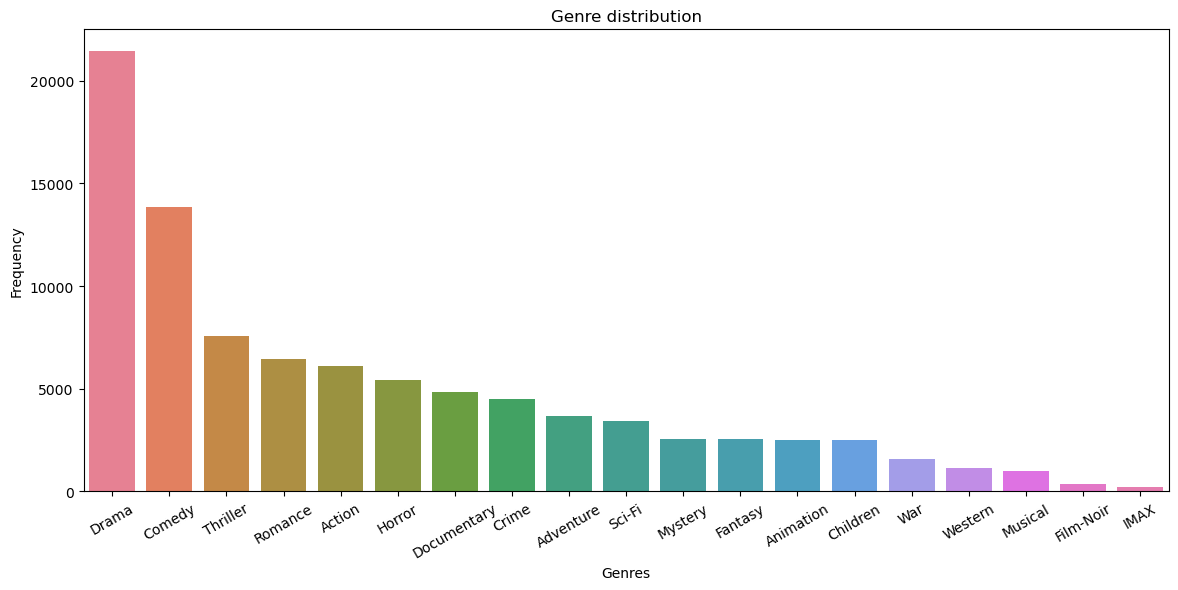

In [45]:
plt.figure(figsize=(14,6))
sns.barplot(x="Genre",y="Count",hue="Genre",data=genre_df)
plt.title("Genre distribution")
plt.xlabel("Genres")
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.show()

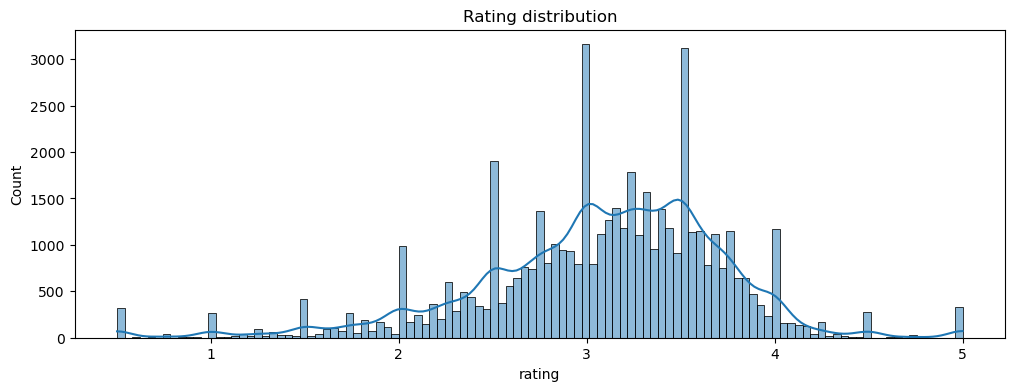

In [46]:
plt.figure(figsize=(12,4))
sns.histplot(data=temp_df,x=temp_df["rating"],kde=True)
plt.title("Rating distribution")
plt.show()

In [47]:
temp_df["rating"].median()

3.16

In [48]:
pos_df=temp_df[temp_df["rating"]>=temp_df["rating"].median()] # Assuming rating >= median are positive reviews
pos_df

,title,genres,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,3.17,ann margaret burgess meredith clv daryl hannah...
5,Heat (1995),Action Crime Thriller,3.86,1 7 5 filmaffinity action al pacino vs robert ...
6,Sabrina (1995),Comedy Romance,3.37,clv drama greg kinnear harrison ford julia orm...
...,...,...,...,...
50142,A Radiant Girl (2022),Drama War,4.00,cannes 2021 france world war ii bittersweet co...
50143,Everybody's Oma (2022),Documentary,4.50,alzheimer 's disease
50144,Sabotage,(no genres listed),3.50,animation auschwitz birkenau concentration cam...
50148,Esperando a Dalí (2023),Comedy Romance,3.50,1974 cadaques gala dali guardia civil salvador...


In [49]:
def clean_text(x):
    clean = x

    clean = re.sub(r"\b(\d+)\s*[a-zA-Z]\b", " ", clean)

    clean = re.sub(r"\b[a-zA-Z]+\d+\b", " ", clean)

    clean = clean.replace("'", " ")

    clean = re.sub(r"\b[a-zA-Z]\b", " ", clean)
    clean = re.sub(r"[^0-9A-Za-z\s]", " ", clean)

    clean = re.sub(r"\s+", " ", clean).strip().lower()

    tokens = clean.split()
    unique_tokens = list(dict.fromkeys(tokens))

    return " ".join(unique_tokens)


In [50]:
pos_df["clean_tags"]=pos_df['clean_tags'].apply(clean_text)

/tmp/ipykernel_2600/414444472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df["clean_tags"]=pos_df['clean_tags'].apply(clean_text)


In [51]:
pos_df["clean_tags"].values[0]

'2009 reissue in stereoscopic dimensional 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey again vhs ta leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat brawl bright brother si

In [52]:
positive_tags=pos_df["clean_tags"].values.tolist()

In [53]:
len(positive_tags)

25219

In [54]:
positive_tags

['2009 reissue in stereoscopic dimensional 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey again vhs ta leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster bo peep character bouncy ball boy next door brat brawl bright brother s

In [55]:
common_words=["director","movie","film",'movies','films','seen']

In [56]:
positive_cleaned_tags = [" ".join([w for w in s.split() if w not in common_words]) for s in positive_tags]

In [57]:
positive_tags=" ".join(positive_cleaned_tags)

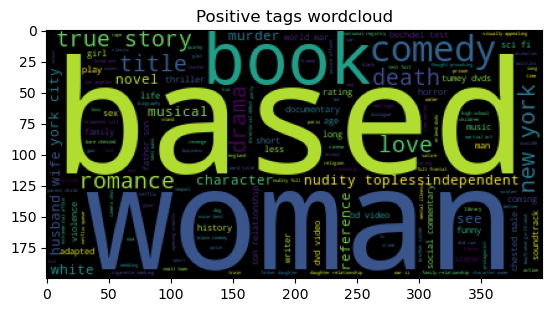

In [58]:
pos_wc=WordCloud(max_words=1000,background_color="black").generate(positive_tags) # Wordcloud to see dominant words
plt.title("Positive tags wordcloud")
plt.imshow(pos_wc)

In [59]:
neg_df=temp_df[temp_df["rating"]<temp_df["rating"].median()] # Assuming rating <3 are bad reviews
neg_df

,title,genres,rating,clean_tags
3,Waiting to Exhale (1995),Comedy Drama Romance,2.87,clv based on novel or book characters chick fl...
4,Father of the Bride Part II (1995),Comedy,3.08,4th wall clv comedy diane keaton fantasy steve...
7,Tom and Huck (1995),Adventure Children,3.12,19th century disney library system mark twain ...
8,Sudden Death (1995),Action,3.00,1990s action clv ca n't remember jean claude v...
11,Dracula: Dead and Loving It (1995),Comedy Horror,2.68,bd r leslie nielsen mel brooks abandoned chape...
...,...,...,...,...
50147,A Corsican Summer (2022),Drama,1.50,ataraxia boredom corsica slow paced summer vil...
50150,The Deep Web: Murdershow (2023),Horror Thriller,1.71,deep web horror thriller
50151,Bird Box Barcelona (2023),Horror Thriller,2.47,apocalypse bad science plot holes post apocaly...
50152,Colaholic (2018),(no genres listed),3.00,addiction animation short film


In [61]:
negative_tags=neg_df["clean_tags"].apply(clean_text)
negative_tags=neg_df["clean_tags"].values.tolist()
negative_cleaned_tags = [" ".join([w for w in s.split() if w not in common_words]) for s in negative_tags]
negative_tags=" ".join(negative_cleaned_tags)

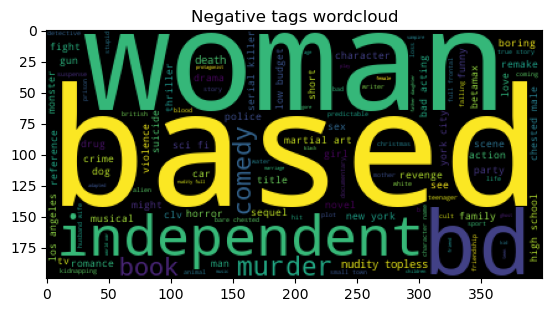

In [62]:
neg_wc=WordCloud(max_words=1000,background_color="black").generate(negative_tags)
plt.title("Negative tags wordcloud")
plt.imshow(neg_wc)

In [64]:
df.to_csv('processed_movie_data.csv') # saving the final dataframe into csv file

In [65]:
df.head(3)

,title,genres,rating,clean_tags
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,3.89,1990s 2009 reissue in stereoscopic 3 d dimensi...
1,Jumanji (1995),Adventure Children Fantasy,3.28,1860s 1960s 1990s 19th century 20th 4k adaptat...
2,Grumpier Old Men (1995),Comedy Romance,3.17,ann margaret burgess meredith clv daryl hannah...


# Model Building

In [ ]:
# Chunking the tags
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)

In [68]:
splitter.split_text(df["clean_tags"].values[0])

["1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely",
 'ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi baby monitor backfire backyard bad guy ballet flats banister battery battleship beautiful bed bedroom binoculars biohazard sign birthday party present blinds blockbuster 

In [69]:
all_docs=[]
all_meta=[]

for i,row in df.iterrows():

    meta={
        "movie_id":i,
        "Title":row["title"],
        "Genres":row["genres"],
        "Rating":row["rating"]
    }

    tags=str(row["clean_tags"])
    tag_chunks=splitter.split_text(tags)

    for chunk_id,chunk in enumerate(tag_chunks):

        chunk_text=(f"Title: {row['title']}\n"
                    f"Genres: {row['genres']}\n"
                    f"Tags: {chunk}")
        
        all_docs.append(chunk_text)
        chunk_meta=meta.copy()
        chunk_meta["chunk_id"]=chunk_id
        all_meta.append(chunk_meta)
        

In [70]:
all_docs[:5]

["Title: Toy Story (1995)\nGenres: Adventure Animation Children Comedy Fantasy\nTags: 1990s 2009 reissue in stereoscopic 3 d dimensional 3d 55 movies every kid should see entertainment weekly american animation bd video best of rotten tomatoes all time buzz lightyear cg cgi classic clv cartoon comedy daring rescues dvd disney animated feature engaging family heroic mission john lasseter national film registry os dois viram oscar picture special achievement owned pixar toys come to life tim allen tom hanks toy story tumey 's again vhs ta c a leoni does not star this movie unlikely",
 'Title: Toy Story (1995)\nGenres: Adventure Animation Children Comedy Fantasy\nTags: ta c a leoni does not star this movie unlikely friendships usa want watched woody accepting reality action figure figures ad for adventure affection alien almost favorite dog fictional tv commercial animmation antenna anthropomorphic anthropomorphism apology arcade game arm asking directions astronaut audio flashback avi ba

In [71]:
all_meta[:5]

[{'movie_id': 0,
  'Title': 'Toy Story (1995)',
  'Genres': 'Adventure Animation Children Comedy Fantasy',
  'Rating': 3.89,
  'chunk_id': 0},
 {'movie_id': 0,
  'Title': 'Toy Story (1995)',
  'Genres': 'Adventure Animation Children Comedy Fantasy',
  'Rating': 3.89,
  'chunk_id': 1},
 {'movie_id': 0,
  'Title': 'Toy Story (1995)',
  'Genres': 'Adventure Animation Children Comedy Fantasy',
  'Rating': 3.89,
  'chunk_id': 2},
 {'movie_id': 0,
  'Title': 'Toy Story (1995)',
  'Genres': 'Adventure Animation Children Comedy Fantasy',
  'Rating': 3.89,
  'chunk_id': 3},
 {'movie_id': 0,
  'Title': 'Toy Story (1995)',
  'Genres': 'Adventure Animation Children Comedy Fantasy',
  'Rating': 3.89,
  'chunk_id': 4}]

In [ ]:
#Storing the data as vector embeddings
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

embeddings=HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [73]:
from langchain_community.vectorstores import FAISS

faiss_store=FAISS.from_texts(texts=all_docs,metadatas=all_meta,embedding=embeddings)

In [ ]:
faiss_store.save_local("movielens_final_embeddings") #saving for easier indexing later

In [ ]:
retriver=faiss_store.as_retriever(search_kwargs={"k":15}) # retriving 15 relevant documents

In [ ]:
q="horror" # test query
do=retriver.invoke(q)
do

[Document(id='1ff9b468-a726-40f8-a814-0a70d266c54c', metadata={'movie_id': 44529, 'Title': 'Nightmare Cinema (2019)', 'Genres': 'Horror', 'Rating': 2.16, 'chunk_id': 0}, page_content='Title: Nightmare Cinema (2019)\nGenres: Horror\nTags: anthology creative horror stories ideological pamphlet mediocre'),
 Document(id='ddacb28c-de23-43ca-a6c5-cd6fb1aab574', metadata={'movie_id': 29294, 'Title': 'Why Horror? (2014)', 'Genres': 'Documentary', 'Rating': 2.57, 'chunk_id': 0}, page_content='Title: Why Horror? (2014)\nGenres: Documentary\nTags: bd r blood documentary fear gore horror icon interview terror woman director'),
 Document(id='6d12067a-da84-429d-98bb-51f848884546', metadata={'movie_id': 47302, 'Title': 'Masters of Horror (2002)', 'Genres': 'Documentary', 'Rating': 2.83, 'chunk_id': 0}, page_content='Title: Masters of Horror (2002)\nGenres: Documentary\nTags: archive footage blood death dream dying fear filmmaking horror interview interviewee killing nightmare terror'),
 Document(id='

In [ ]:
for x in do:
    print(x.metadata) # extracted documents wrt query

{'movie_id': 44529, 'Title': 'Nightmare Cinema (2019)', 'Genres': 'Horror', 'Rating': 2.16, 'chunk_id': 0}
{'movie_id': 29294, 'Title': 'Why Horror? (2014)', 'Genres': 'Documentary', 'Rating': 2.57, 'chunk_id': 0}
{'movie_id': 47302, 'Title': 'Masters of Horror (2002)', 'Genres': 'Documentary', 'Rating': 2.83, 'chunk_id': 0}
{'movie_id': 49857, 'Title': 'Fear (2023)', 'Genres': 'Horror', 'Rating': 2.5, 'chunk_id': 0}
{'movie_id': 14118, 'Title': 'Dread (2009)', 'Genres': 'Horror', 'Rating': 2.63, 'chunk_id': 0}
{'movie_id': 32831, 'Title': 'Fear Itself (2015)', 'Genres': 'Documentary Horror Mystery', 'Rating': 3.5, 'chunk_id': 0}
{'movie_id': 44861, 'Title': 'Haunt (2019)', 'Genres': 'Horror Thriller', 'Rating': 3.24, 'chunk_id': 0}
{'movie_id': 11357, 'Title': 'Halloween (2007)', 'Genres': 'Horror', 'Rating': 2.98, 'chunk_id': 1}
{'movie_id': 40998, 'Title': 'Haunters: The Art of the Scare (2017)', 'Genres': 'Documentary', 'Rating': 3.5, 'chunk_id': 0}
{'movie_id': 27901, 'Title': 'Ni

In [ ]:
retrived_documents=[]
for x in do:
    retrived_documents.append(f"Title: {x.metadata['Title']}, Genres: {x.metadata['Genres']}, Rating: {x.metadata['Rating']}")
retrived_documents #retrived titles

['Title: Nightmare Cinema (2019), Genres: Horror, Rating: 2.16',
 'Title: Why Horror? (2014), Genres: Documentary, Rating: 2.57',
 'Title: Masters of Horror (2002), Genres: Documentary, Rating: 2.83',
 'Title: Fear (2023), Genres: Horror, Rating: 2.5',
 'Title: Dread (2009), Genres: Horror, Rating: 2.63',
 'Title: Fear Itself (2015), Genres: Documentary Horror Mystery, Rating: 3.5',
 'Title: Haunt (2019), Genres: Horror Thriller, Rating: 3.24',
 'Title: Halloween (2007), Genres: Horror, Rating: 2.98',
 'Title: Haunters: The Art of the Scare (2017), Genres: Documentary, Rating: 3.5',
 'Title: Nightmare (1981), Genres: Horror, Rating: 2.91',
 'Title: Satanic (2006), Genres: Horror, Rating: 2.0',
 "Title: The Making of 'Nightmare on Elm Street IV' (1989), Genres: Documentary, Rating: 4.0",
 'Title: Grave Halloween (2013), Genres: Horror, Rating: 2.17',
 'Title: The Nightmare (2015), Genres: Documentary, Rating: 3.2',
 'Title: Vile (2011) , Genres: Horror, Rating: 2.34']

In [81]:
retrived_documents=" ".join(retrived_documents)

retrived_documents

"Title: Nightmare Cinema (2019), Genres: Horror, Rating: 2.16 Title: Why Horror? (2014), Genres: Documentary, Rating: 2.57 Title: Masters of Horror (2002), Genres: Documentary, Rating: 2.83 Title: Fear (2023), Genres: Horror, Rating: 2.5 Title: Dread (2009), Genres: Horror, Rating: 2.63 Title: Fear Itself (2015), Genres: Documentary Horror Mystery, Rating: 3.5 Title: Haunt (2019), Genres: Horror Thriller, Rating: 3.24 Title: Halloween (2007), Genres: Horror, Rating: 2.98 Title: Haunters: The Art of the Scare (2017), Genres: Documentary, Rating: 3.5 Title: Nightmare (1981), Genres: Horror, Rating: 2.91 Title: Satanic (2006), Genres: Horror, Rating: 2.0 Title: The Making of 'Nightmare on Elm Street IV' (1989), Genres: Documentary, Rating: 4.0 Title: Grave Halloween (2013), Genres: Horror, Rating: 2.17 Title: The Nightmare (2015), Genres: Documentary, Rating: 3.2 Title: Vile (2011) , Genres: Horror, Rating: 2.34"

# RAG

In [83]:
from all_api import groq_api
from langchain_groq import ChatGroq

In [84]:
llm=ChatGroq(api_key=groq_api,model="llama-3.1-8b-instant")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a movie-description assistant. You are NOT allowed to invent movies, ratings, years, actors, directors, or plot details.\n"
        "Your ONLY knowledge source is the movie list provided by the user.\n\n"
        "For each movie in the list:\n"
        "1. Use ONLY the title, genres, and tags implied by the retrieval context.\n"
        "2. Generate a short 2–3 sentence description capturing the movie's tone, style, and themes.\n"
        "3. If tags imply horror, supernatural, documentary, thriller, etc., reflect that in the description.\n"
        "4. Do NOT mention actors, release year, plot points, or production details unless they appear explicitly.\n"
        "5. Keep the descriptions engaging, concise, and human-sounding.\n"
        "6. Re-rank the movies order based on the ratings given and display top 7 movies based on ranking and describe only them.\n"
        "DON'T DESCRIBE EVERY MOVIE JUST TOP RATED MOVIES ACCORDING TO THE RANKING ORDER"
    ),
    (
        "user",
        "Generate descriptions for the following movies:\n{context}"
    )
])

In [86]:
from langchain_core.output_parsers import StrOutputParser
output=StrOutputParser()

chain=prompt|llm|output

In [87]:
response=chain.invoke({'context':retrived_documents})
print(response)

Based on the provided list, here are the descriptions for the top-rated movies:

1. **The Making of 'Nightmare on Elm Street IV'** (Documentary, Rating: 4.0)
This documentary offers an in-depth look at the making of a horror classic, providing a behind-the-scenes glimpse into the creative process and the challenges faced by the filmmakers.

2. **Fear Itself** (Documentary Horror Mystery, Rating: 3.5)
This documentary delves into the world of horror, exploring the genre's themes and conventions through interviews and real-life examples, creating a chilling and thought-provoking experience.

3. **Haunters: The Art of the Scare** (Documentary, Rating: 3.5)
This documentary examines the art of scaring, showcasing the techniques and talents of professional haunters and exploring the psychology behind fear and the thrill of being scared.

4. **The Nightmare** (Documentary, Rating: 3.2)
This documentary offers a unique perspective on the world of sleep disorders, exploring the terrifying expe